# Project

* Le but est de développer une application utilisant un réseau de neurones pour prédire le chiffre à partir d'une image de la base de données MNIST.

In [1]:
# used for manipulating directory paths
import os

import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization (minimize) module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat
#Import to be used for visualization 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib.image as mpimg
# tells matplotlib to embed plots within the notebook
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Chargement des données

On va importer le fichier `ex4data1.mat`,contenu dans mon fichier Telechargement dont il y a un ensemble de 5000 exemples d'entaînement, chacun étant constitué d'une image de taille $20 \times 20$ en niveaux de gris avec son étiquette qui représente le chiffre inscrit sur l'image. 
Chaque image est modélisée par une matrice de pixels.

Comme cette base de données a été conçue à l'origine pour être utilisées sous MATLAB où il n'y a pas d'indice 0 (Le chiffre 0 a donc été mappé à 10), on va donc mapper le chiffre zéro à 0.

In [2]:
data = loadmat('ex4data1.mat')#ce fichier se trouve dans mon fichier telechargement
X, y = data['X'], data['y'].ravel()

# mapper le chiffre zéro à 0.

y[y == 10] = 0


print(X.shape, y.shape)

(5000, 400) (5000,)


In [3]:
import scipy.io
import pandas as pd

mat = scipy.io.loadmat('ex4data1.mat')
mat = {k:v for k, v in mat.items() if k[0] != '_'}
datacsv = pd.DataFrame({k: pd.Series(v[0]) for k, v in mat.items()}) # compatible for both python 2.x and python 3.x

datacsv.to_csv("ex4data1.csv")

In [4]:
datacsv.head(10)

,X,y
0,0.0,10.0
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN
5,0.0,NaN
6,0.0,NaN
7,0.0,NaN
8,0.0,NaN
9,0.0,NaN


# Répartition de la base de données entre train_set et test_set

*on va utiliser KFold pour subdiviser la base de données en 21 parties:*
Test_Set sera bien sur le 14, indice de notre groupe,  le parametre de kF random_state sera donc 14.
 La taile de chaque lot:  **5000//21=238**

In [5]:
kF = KFold(n_splits= 21 , shuffle=True , random_state=14)#on peur utiliser la fonction random.seed(14) afin d'aboutir à cela [Le partitionnement de la base doit être aléatoire avec un seed égale à l'indice de votre groupe (pour la reproduction des résultats)]
a=0
for train_index ,test_index in kF.split(X, y) :
    if (a == 14) :
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        break
    a=a+1



In [6]:
print(" Shape of X_train : " , X_train.shape ,"\n Shape of y_train : " , y_train.shape,"\n Shape of X_test : " , X_test.shape,"\n Shape of y_test : " , y_test.shape) 


 Shape of X_train :  (4762, 400) 
 Shape of y_train :  (4762,) 
 Shape of X_test :  (238, 400) 
 Shape of y_test :  (238,)


#  Initialisation aléatoire de Weights

In [7]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    
    return W

In [8]:
def nn_initial_params(list_p):
    list_initial_thetas =[]
    nb_layers = len(list_p)
    
    for i in range (nb_layers-1):
        initial_Theta = randInitializeWeights(list_p[i],list_p[i+1])
        list_initial_thetas.append(initial_Theta.ravel())
        
    initial_nn_params = np.concatenate(list_initial_thetas, axis=0)
    print('Initialisation des parametres du Neural Network ...')
    
    return initial_nn_params


# Contruction

* le réseau de neurones doit être flexible, et doit donc accepter un nombre quelconque de couches et un nombre de neouds quelconque par couche. 


**la fonction d'activation sigmoid:**

$$ \text{sigmoid}(z) = \frac{1}{1 + e^{-z}} $$ $$\text{d_sigmoid}(z)=sigmoid(z)(1-sigmoid(z))$$

In [9]:
#Computes the sigmoid of z.
def sigmoid(z):
    
    return 1.0 / (1.0 + np.exp(-z))


#Computes the sigmoid Gradient of z.
def sigmoidGradient(z):
    sg = sigmoid(z) * (1 - sigmoid(z))
    return sg

In [10]:
def make_nn_params( nn_params, list_p):
    nb_layers = len(list_p)
    list_thetas = []
    start = 0
    end = 0
    for k in range (nb_layers-1):
        end += list_p[k+1] * (list_p[k] + 1)
        theta = np.reshape(nn_params[start:end], (list_p[k+1], (list_p[k] + 1)))
        list_thetas.append(theta)
        start = end 
    return list_thetas

**la fonction make_nn() doit contenir les deux parties feed forward et backpropagation** 

* Dans cette fonction l'information ne se déplace que dans une seule direction, vers l'avant, à partir des nœuds d'entrée, en passant par les couches cachées (le cas échéant) et vers les noeuds de sortie. Il n'y a pas de cycles ou de boucles dans le réseau

* back_propagation est une fonction pour calculer le gradient de l'erreur pour chaque neurone d'un réseau de neurones, de la dernière couche vers la première.

In [13]:
def make_nn( nn_params, list_p , X , y  , lambda_):
    nb_layers = len(list_p)
    num_labels = list_p[nb_layers - 1]
        
    list_thetas = make_nn_params( nn_params, list_p)
    
    m = y.size
    
    # map y vectors into binary vectors of 1's and 0's
    
    yVec = np.zeros((m,num_labels))
    
    for k in range(m):
        yVec[k][y[k]] = 1
        
    #on appelle feed forward.
    
    a_prev = X
    list_a =[]  
    for i in range (nb_layers-1):
        a_prev = np.concatenate([np.ones((a_prev.shape[0], 1)), a_prev], axis=1)
        list_a.append(a_prev)
        a_next = sigmoid(np.dot(a_prev,list_thetas[i].T))
        a_prev = a_next
        
    a_last = a_next
    
    #Cost Function with Regularization 
    
    reg = 0
    
    for i in range (nb_layers-1) :
        reg += (lambda_ /(2*m)) * np.sum(np.square(list_thetas[i][:, 1:]))
        
    J = (-1/m) * np.sum((np.log(a_last) * yVec) + np.log(1 - a_last) * (1 - yVec)) + reg
        
    #on appelle backpropogation.
    
    delta = a_last - yVec
    list_delta =[a_last - yVec] # la liste des delta est donc de la derniere vers la premiere 
    for i in range (nb_layers-2 , 0 ,-1):
        delta = delta.dot(list_thetas[i])[:, 1:] * sigmoidGradient(list_a[i-1].dot((list_thetas[i-1]).T))
        list_delta.append(delta)
    
    # Gradient with Regularization
    
    list_Thetas_grad = []
    for i in range(nb_layers-1) :
        a=list_a[i]
        g =list_delta[nb_layers-2-i].T
        Delta = g.dot(a)
        thetaGrad = (1 / m) * Delta
        thetaGrad[:, 1:] +=  (lambda_/m) * list_thetas[i][:,1:]
        list_Thetas_grad.append(thetaGrad.ravel())
        
    gradient = np.concatenate(list_Thetas_grad) 
    
    return J, gradient 

In [14]:
nb_features = 400 
nb_classes = 10   

# notre nn architecture d'indice 14

list_p = [nb_features, 17, 16, nb_classes]

options= {'maxiter': 400} #400 est donc le max des itérations 

lambda_ = 1

# Initialisation des  nn_parameters 

initial_nn_params = nn_initial_params(list_p)

nn_model = lambda p: make_nn(p, list_p , X_train, y_train, lambda_)# pour que la fonction make_nn prend en argument nn_model.

res = optimize.minimize(nn_model, initial_nn_params, jac=True, method='TNC', options=options)
print("l'apprentissage des parametres établie" )
nn_params = res.x #sauvegarder le resultat 

Initialisation des parametres du Neural Network ...
l'apprentissage des parametres établie


# Finalisation

In [15]:
def predict(X , nn_params, list_p):
    m = X.shape[0]
    nb_layers = len(list_p)

    list_thetas = make_nn_params( nn_params, list_p) #cette liste se trouve deja dans nn_params

    #lancement des predictions
    h = X
    for i in range (nb_layers-1) :
        h = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h], axis=1), list_thetas[i].T))
        p = np.argmax(h, axis=1)
    return p


**Accuracy Comparaison**

In [16]:
predtrain = predict(X_train, nn_params,list_p)
print('Training Set Accuracy: %f' % (np.mean(predtrain == y_train) * 100))
#ceci afin de faire une comparaison entre les deux accrurencies.
predtest = predict(X_test , nn_params,list_p)
print('Testing Set Accuracy: %f' % (np.mean(predtest == y_test) * 100))

Training Set Accuracy: 99.790004
Testing Set Accuracy: 92.016807


# Confusion matrix
* la diagonale comporte les valeurs les plus élevées, ce qui est un bon signe pour l'accurency de detection de chaque nombre.
par exemple la premiere colonne derniere ligne ça signifie que un nombre 9 est considere comme un 0.
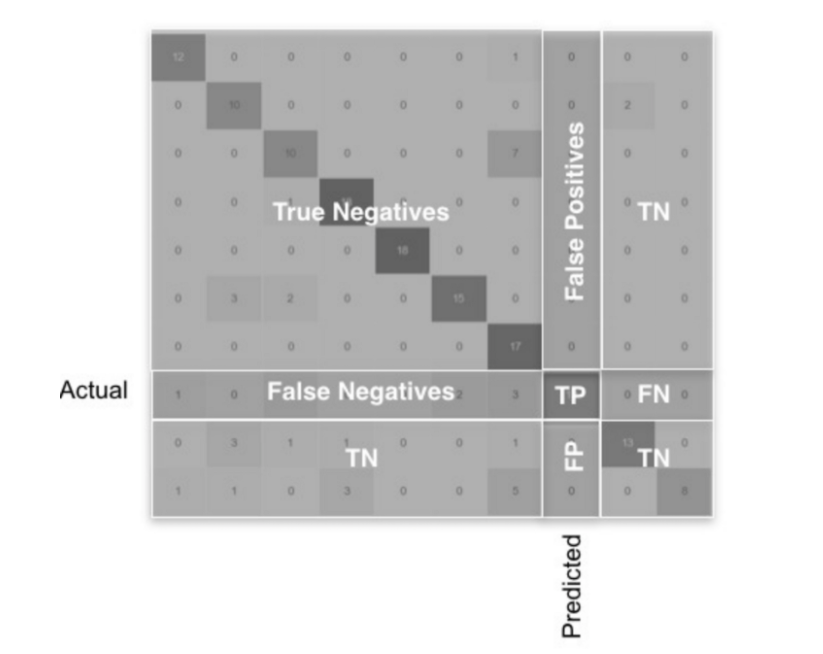

In [17]:
from sklearn import metrics
print(metrics.confusion_matrix(y_train, predtrain))

[[479   0   0   0   0   0   0   0   0   0]
 [  0 473   0   0   0   0   0   1   0   0]
 [  0   1 478   0   0   0   0   0   0   0]
 [  0   1   0 475   0   0   0   1   1   0]
 [  0   0   0   0 480   0   0   0   0   0]
 [  1   0   0   0   0 468   0   0   0   0]
 [  0   0   0   0   0   0 479   0   0   0]
 [  0   1   0   0   0   0   0 470   0   0]
 [  1   0   0   0   0   0   0   0 474   0]
 [  1   0   0   1   0   0   0   0   0 476]]


* le test de la base de données en utilisant Sklearn.metrics

In [18]:
print(" ** Testing Dataset Evaluation ** ")

accuracy = accuracy_score(y_test, predtest)

precision = precision_score(y_test, predtest, average='weighted')

recall = recall_score(y_test, predtest, average='weighted')

f1 = f1_score(y_test, predtest , average='weighted')

print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision) 
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

 ** Testing Dataset Evaluation ** 
Accuracy: 0.920168
Precision: 0.923425
Recall: 0.920168
F1 score: 0.920461


# BD

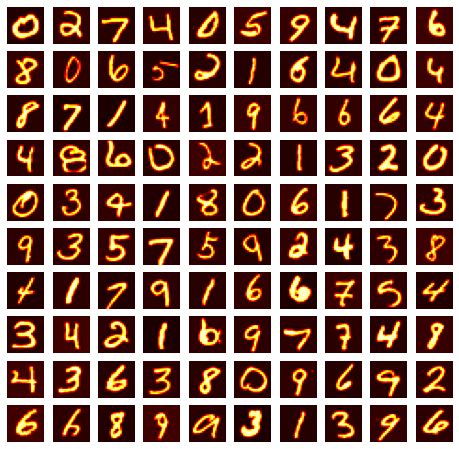

In [19]:
mat=loadmat("ex4data1.mat")
X=mat["X"]
y=mat["y"]

fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot")#for better visualisation
        axis[i,j].axis("off")